# Implement a simple neural network
refer to [Implementing a Neural Network from Scratch in Python – An Introduction](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/)

In [3]:
%matplotlib inline

In [20]:
import numpy as np
import sklearn.datasets
import sklearn.linear_model
import matplotlib.pyplot as plt
import matplotlib

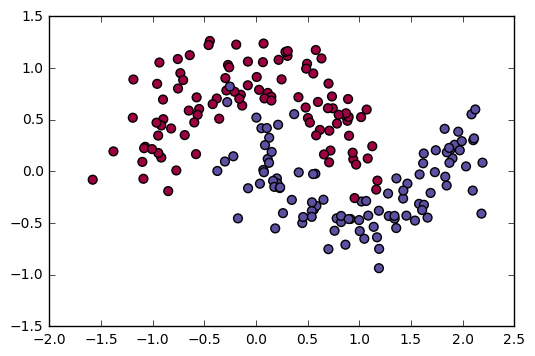

In [5]:
# generate a dataset
np.random.seed(123)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap = plt.cm.Spectral)

Predictions
$$
\begin{array}{ll}
z_m & = \sigma(\alpha_{0m}+\alpha_m^TX)\qquad m=1,\ldots, M\\
T_k &= \beta_{0k}+\beta_k^TZ\qquad k=1,\ldots, K\\
f_k(X)&=g_k(T)=\frac{exp(T_k)}{\sum_{\ell=1}^Kexp(T_\ell)}
\end{array}
$$

Loss function
$$
L = -\frac 1N \sum\limits_{i=1}^NL_i
$$
where
$$
\begin{array}{ll}
L_i& = \sum\limits_{k=1}^Ky_{ik}logf_k(x_i) \\
&=\sum\limits_{k=1}^Ky_{ik}(T_k-log(\sum_{\ell=1}^Kexp(T_\ell)))\\
&=\sum\limits_{k=1}^Ky_{ik}T_k-log(\sum_{\ell=1}^Kexp(T_\ell))\\
\end{array}
$$

BP formula
$$
\begin{array}{lll}
\frac{\partial L_i}{\partial \beta_{km}} &=& \frac{\partial L_i}{\partial T_k}\frac{\partial T_k}{\partial \beta_{km}}\\
&=&(y_{ik}-f_k(x_i))z_{mi}\\
&=&\delta_{ki}z_{mi}
\end{array}
$$
Thus, we have $\frac{\partial L_i}{\partial \beta_{k0}}=\delta_{ki}, \frac{\partial L_i}{\partial \beta_{km}}=\delta_{ki}z_{mi}$
$$
\begin{array}{lll}
\frac{\partial L_i}{\partial \alpha_{m\ell}} &=&\sum\limits_{k=1}^K \frac{\partial L_i}{\partial T_k}\frac{\partial T_k}{\partial z_{m}}\frac{\partial z_m}{\partial \alpha_{m\ell}}\\
&=&\sigma'(\alpha_{0m}+\alpha_m^TX)\sum\limits_{k=1}^K\delta_{ki}\beta_{km}x_{i\ell}\\
&=&s_{mi}x_{i\ell}
\end{array}
$$
Thus, we have $\frac{\partial L_i}{\partial \alpha_{m\ell}}=s_{mi}, \frac{\partial L_i}{\partial \alpha_{m\ell}}=s_{mi}x_{i\ell}$

Here, $\sigma(v)=tanh(v)$, so then $tanh'v=1-tanh^2v$. Also, denote $\boldsymbol\beta=(\beta_{km})_{K\times M}, \boldsymbol\alpha=(\alpha_{m\ell})_{M\times L}$

In [6]:
num_examples = len(X)
nn_input_dim = 2
nn_output_dim = 2
# learning rate for gradient descent
gamma = 0.01
# regularization strength
reg_lambda = 0.01

In [10]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    alpha, a, beta, b = model['alpha'], model['a'], model['beta'], model['b']
    # forward pass to calculate the predictions
    z = np.tanh(X.dot(alpha) + a) # N*L * L*M
    T = np.exp(z.dot(beta) + b) # N*M * M*K
    probs = T / np.sum(T, axis = 1, keepdims=True) # sum by row and get N*1
    # calculate the loss
    logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(logprobs)
    # add regularization term
    data_loss += reg_lambda/2 * (np.sum(np.square(alpha)) + np.sum(np.square(beta)))
    return 1./num_examples * data_loss

In [11]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    alpha, a, beta, b = model['alpha'], model['a'], model['beta'], model['b']
    # forward pass
    z = np.tanh(X.dot(alpha) + a) # N*L * L*M
    T = np.exp(z.dot(beta) + b) # N*M * M*K
    probs = T / np.sum(T, axis = 1, keepdims=True) # sum by row and get N*1
    return np.argmax(probs, axis=1)

In [21]:
# Helper function to plot a decision boundary
def plot_decision_boundary(pred_func):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap = plt.cm.Spectral)

In [16]:
# model
def build_model(nn_hdim, num_passes = 2000, print_loss = False):
    # initialize
    np.random.seed(123)
    alpha = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    a = np.zeros((1, nn_hdim))
    beta = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b = np.zeros((1, nn_output_dim))
    
    model = {}
    
    # gradient descent
    for i in xrange(0, num_passes):
        
        # forward pass
        z = np.tanh(X.dot(alpha) + a) # N*L * L*M
        T = np.exp(z.dot(beta) + b) # N*M * M*K
        probs = T / np.sum(T, axis = 1, keepdims=True)
        
        # back propagation
        delta = probs
        delta[range(num_examples), y] -= 1 # pay attention! because y_ik = 1 for the corresponding class
        dbeta = (z.T).dot(delta)
        db = np.sum(delta, axis=0, keepdims = True)
        s = delta.dot(beta.T) * (1-np.power(z, 2))
        dalpha = np.dot(X.T, s)
        da = np.sum(s, axis=0)
        
        #add regularization term
        dbeta += reg_lambda * beta
        dalpha += reg_lambda * alpha
        
        # gradient descent 
        alpha += -gamma * dalpha
        a += -gamma * da
        beta += -gamma * dbeta
        b += -gamma *db
        
        # assign new parameters to the model
        model = {'alpha': alpha, 'a': a, 'beta': beta, 'b':b}
        
        if print_loss and i %100 ==0:
            print "Loss after iteration %i: %f" %(i, calculate_loss(model))
    return model

In [17]:
# build model
model = build_model(3, print_loss=True)

Loss after iteration 0: 0.604434
Loss after iteration 100: 0.302863
Loss after iteration 200: 0.125740
Loss after iteration 300: 0.083622
Loss after iteration 400: 0.078040
Loss after iteration 500: 0.075535
Loss after iteration 600: 0.073808
Loss after iteration 700: 0.072311
Loss after iteration 800: 0.070842
Loss after iteration 900: 0.069394
Loss after iteration 1000: 0.068051
Loss after iteration 1100: 0.066872
Loss after iteration 1200: 0.065865
Loss after iteration 1300: 0.065013
Loss after iteration 1400: 0.064316
Loss after iteration 1500: 0.066696
Loss after iteration 1600: 0.065865
Loss after iteration 1700: 0.065327
Loss after iteration 1800: 0.064931
Loss after iteration 1900: 0.064617


In [22]:
# plot
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

ValueError: cannot reshape array of size 200 into shape (320,478)